# Doublet detection

## Motivation

So far, we have removed cells that potentially reflect doublets based only on their high count content. We have also filtered based on sample-wise distribution. Now, we will focus on heterotypic doublets. With ADT data, we can detect them using cell type specific surface markers{cite}`Sun2021`.

## Environment setup

In [1]:
import scanpy as sc
import muon as mu
import pandas as pd
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [2]:
filtered_norm_mu_path = "/lustre/groups/ml01/workspace/ciro.suastegui/bp2.0/data/neurips_cite_pp_filtered-qc-norm.h5mu"
filtered_xdbt_mu_path = "/lustre/groups/ml01/workspace/ciro.suastegui/bp2.0/data/neurips_cite_pp_filtered-qc-norm-xdbt.h5mu"

In [3]:
filtered = mu.read(filtered_norm_mu_path)

## Doublets detected with cell type markers

We are now going to look at cell type markers that are mutually exclusive. Some examples are CD3 (T cell marker) vs CD19 (B cell marker) to identify T/B cells doublets.
As cells expressing both specific B and T cell markers do not exist in the physiological condition, those droplets most likely contain more than one cell.

The same is true for cells both expressing T cell (CD3) and Monocyte (CD14) markers.

In [4]:
filtered

MuData object with n_obs × n_vars = 120502 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	120502 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	120502 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      layers:	'counts'

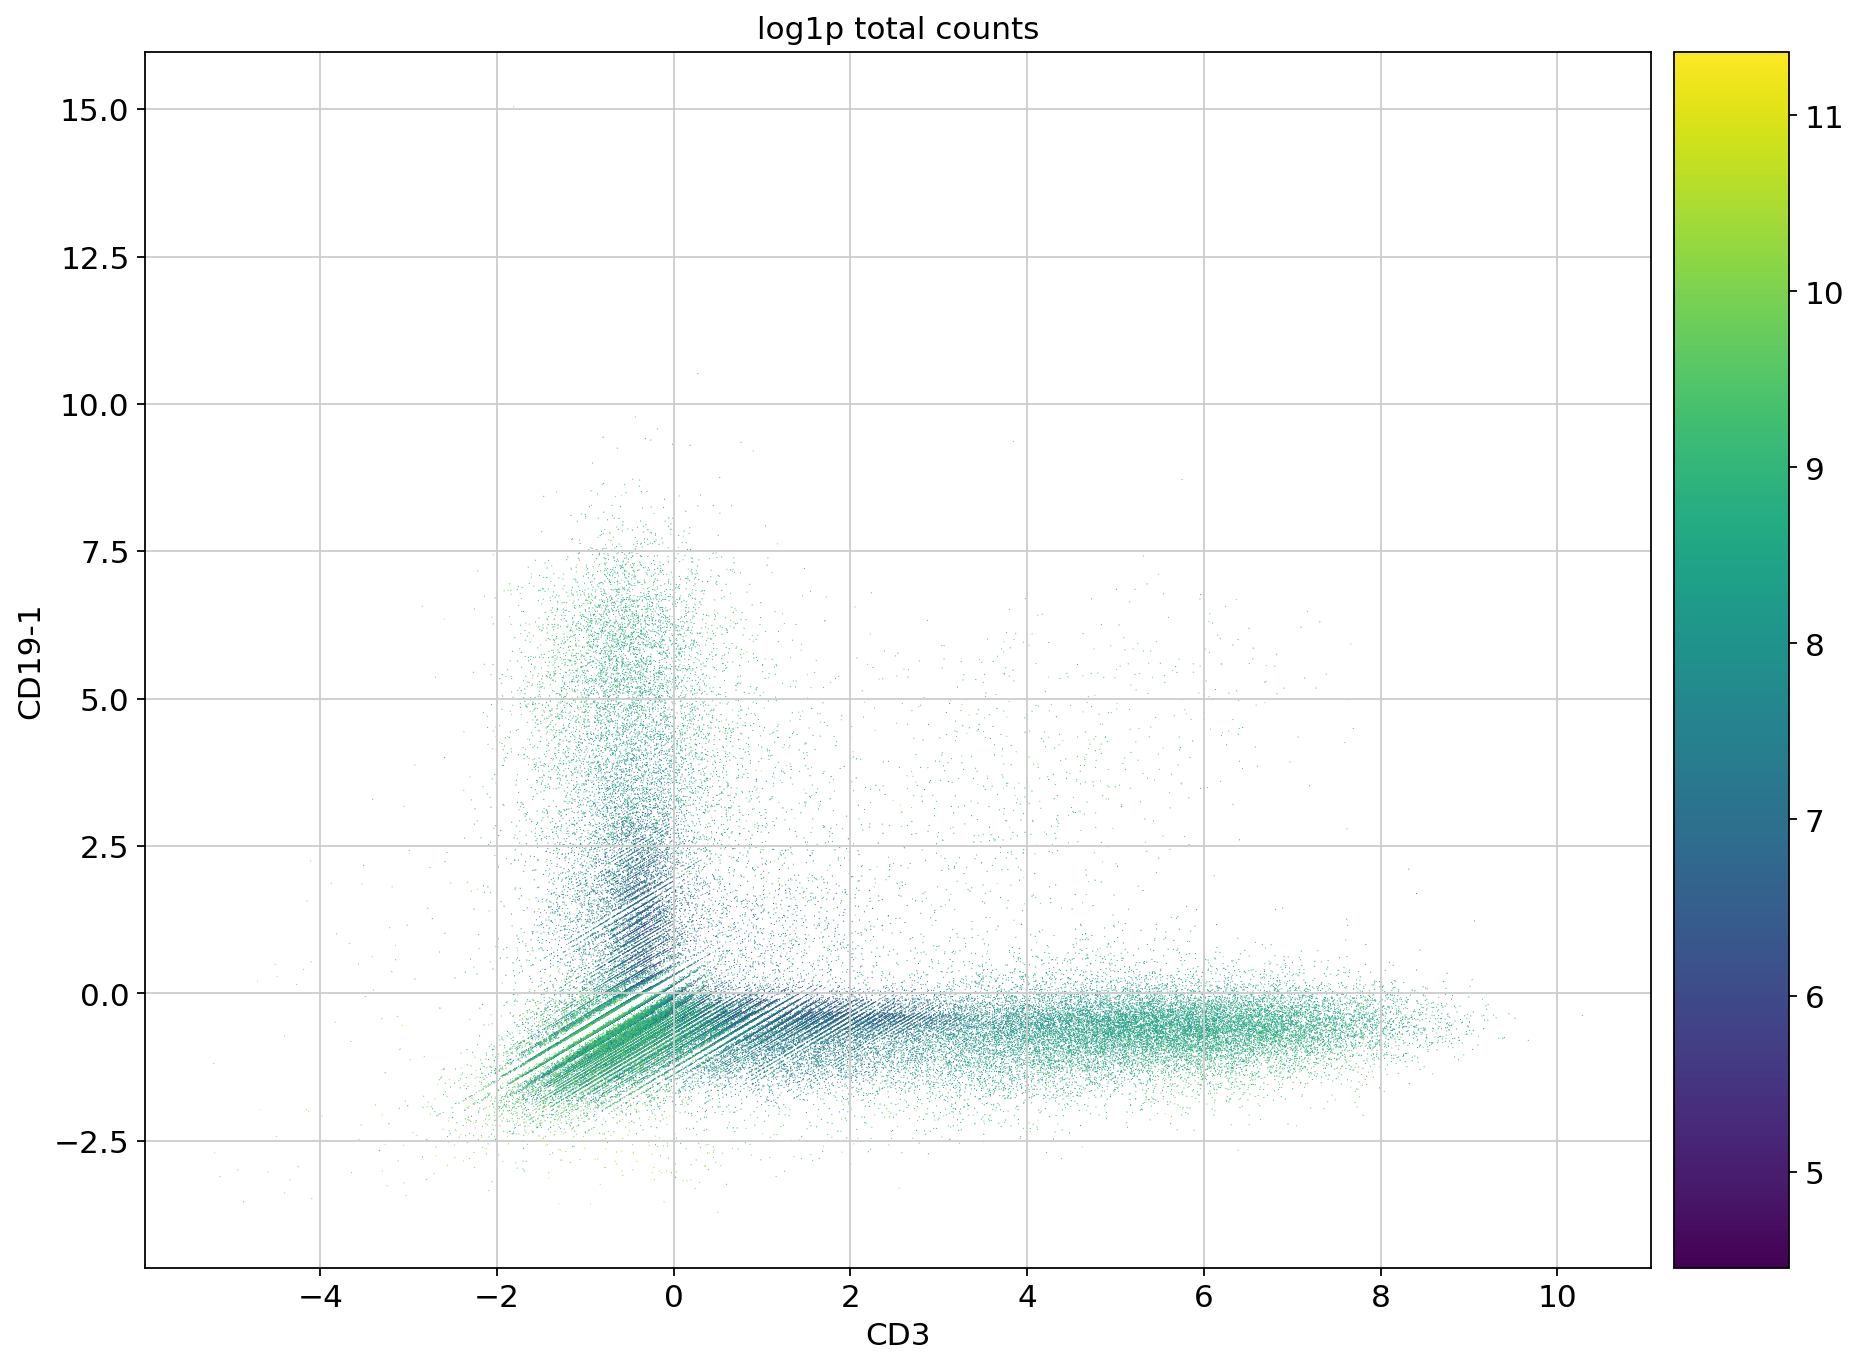

In [5]:
sc.pl.scatter(filtered["prot"], x="CD3", y="CD19-1", color="log1p_total_counts")

In this plot, we can see a large amount of cells not expressing T or B cell markers in the lower left, cells expressing only one marker in the upper left and lower right as well as some cells expressing both markers (upper right).

The cells expressing both markers are most likely doublets and can be removed.

We can also use CD3 and CD14 to detect T/Monocytes doublets.

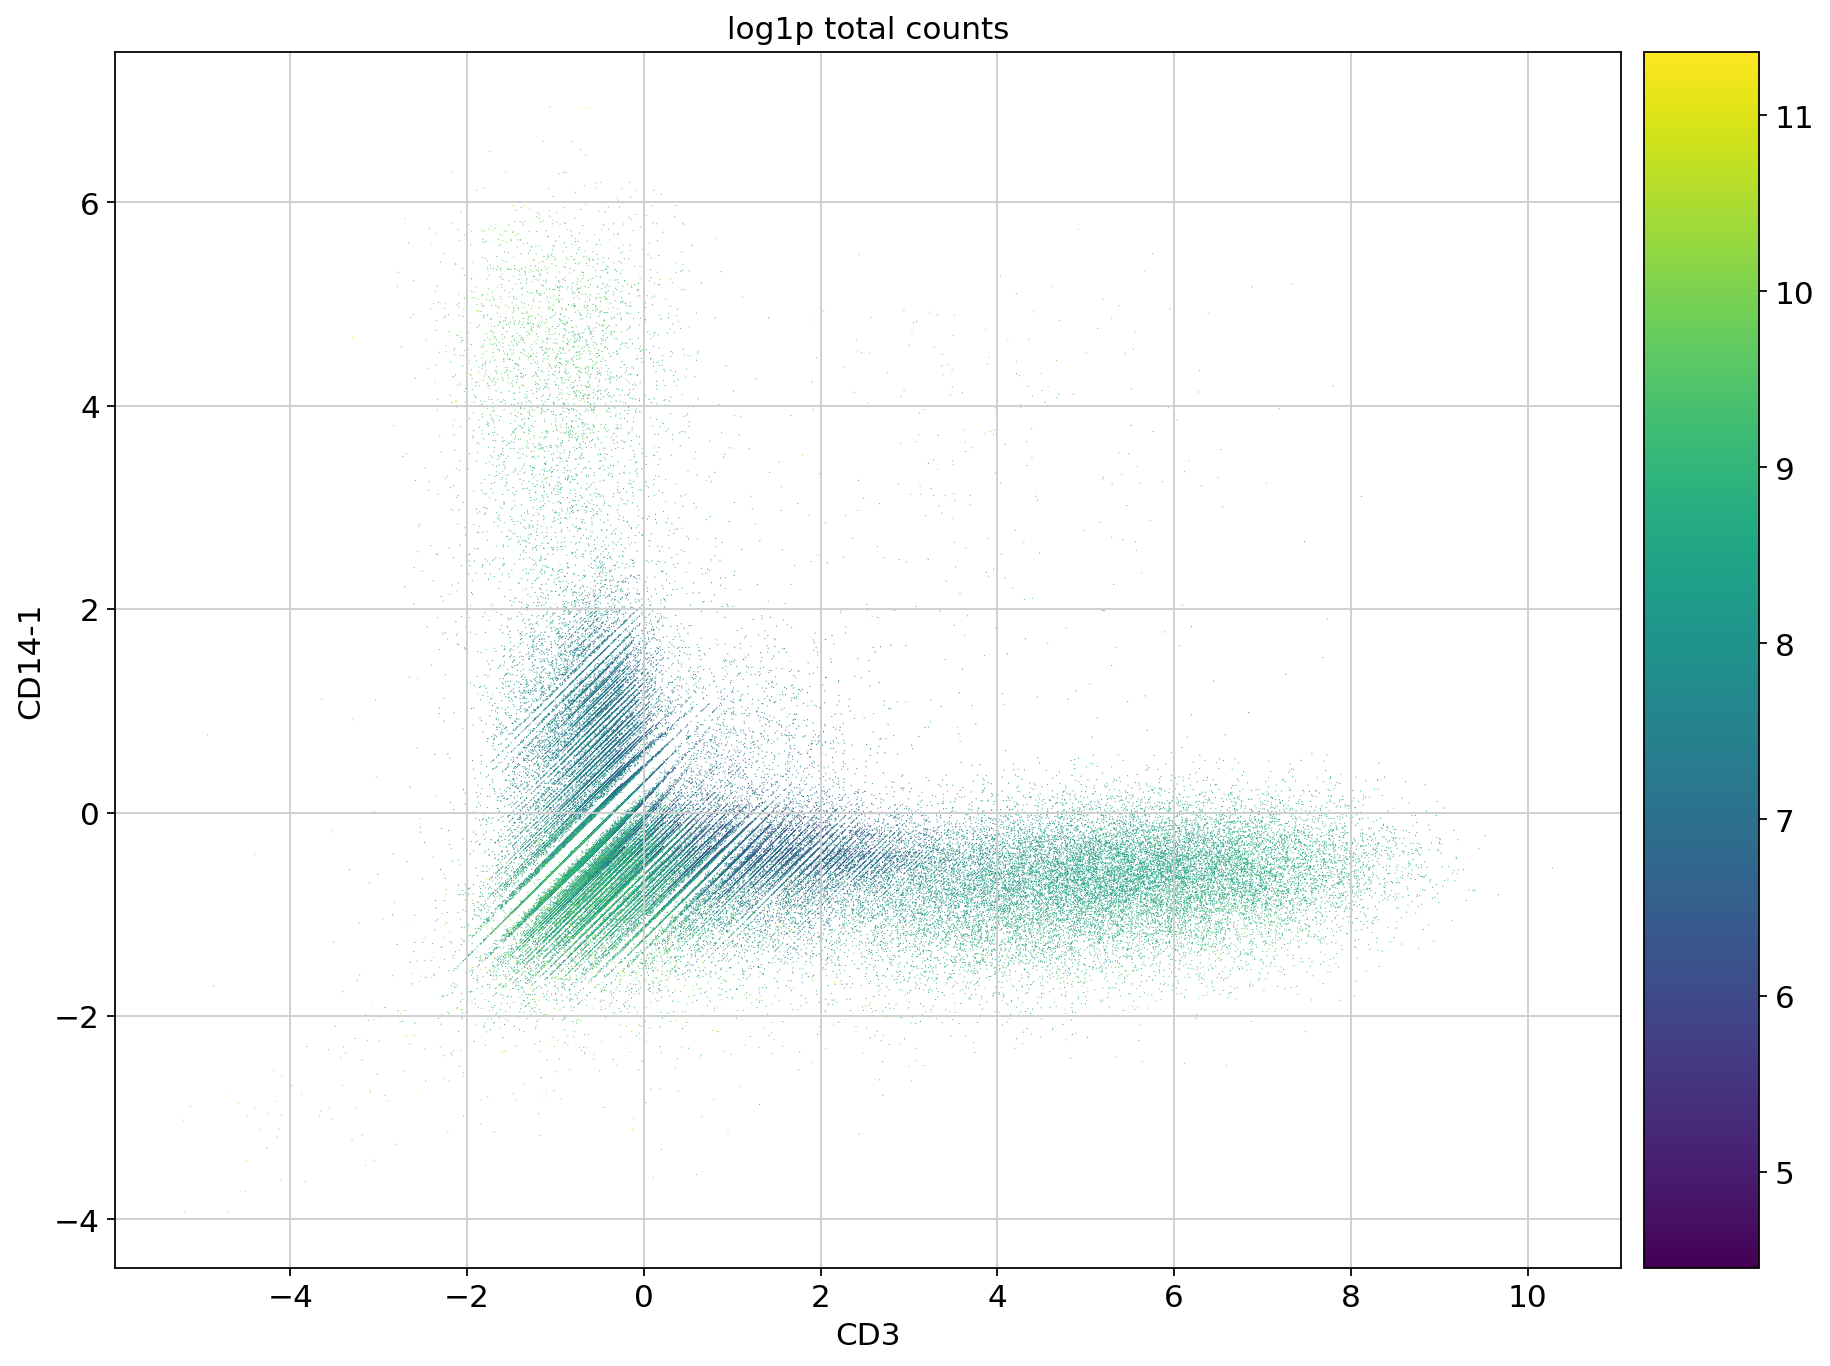

In [6]:
sc.pl.scatter(filtered["prot"], x="CD3", y="CD14-1", color="log1p_total_counts")

It looks like the change in distribution is around 2.5. We could use an expression level above 2.5 of at least two incompatible markers as our threshold to flag doublets.

In [7]:
genes2filter = ["CD3", "CD19-1", "CD14-1"]
temp = filtered["prot"][:, genes2filter].X.T.tolist()

In [8]:
filtered["prot"].obs["doublets_markers"] = [
    (temp[0][i] > 2.5 and temp[1][i] > 2.5) or (temp[0][i] > 2.5 and temp[2][i] > 2.5)
    for i in range(filtered.shape[0])
]
filtered["prot"].obs["doublets_markers"] = (
    filtered["prot"].obs["doublets_markers"].astype(str)
)

We leave out cells expressing both markers.

... storing 'doublets_markers' as categorical


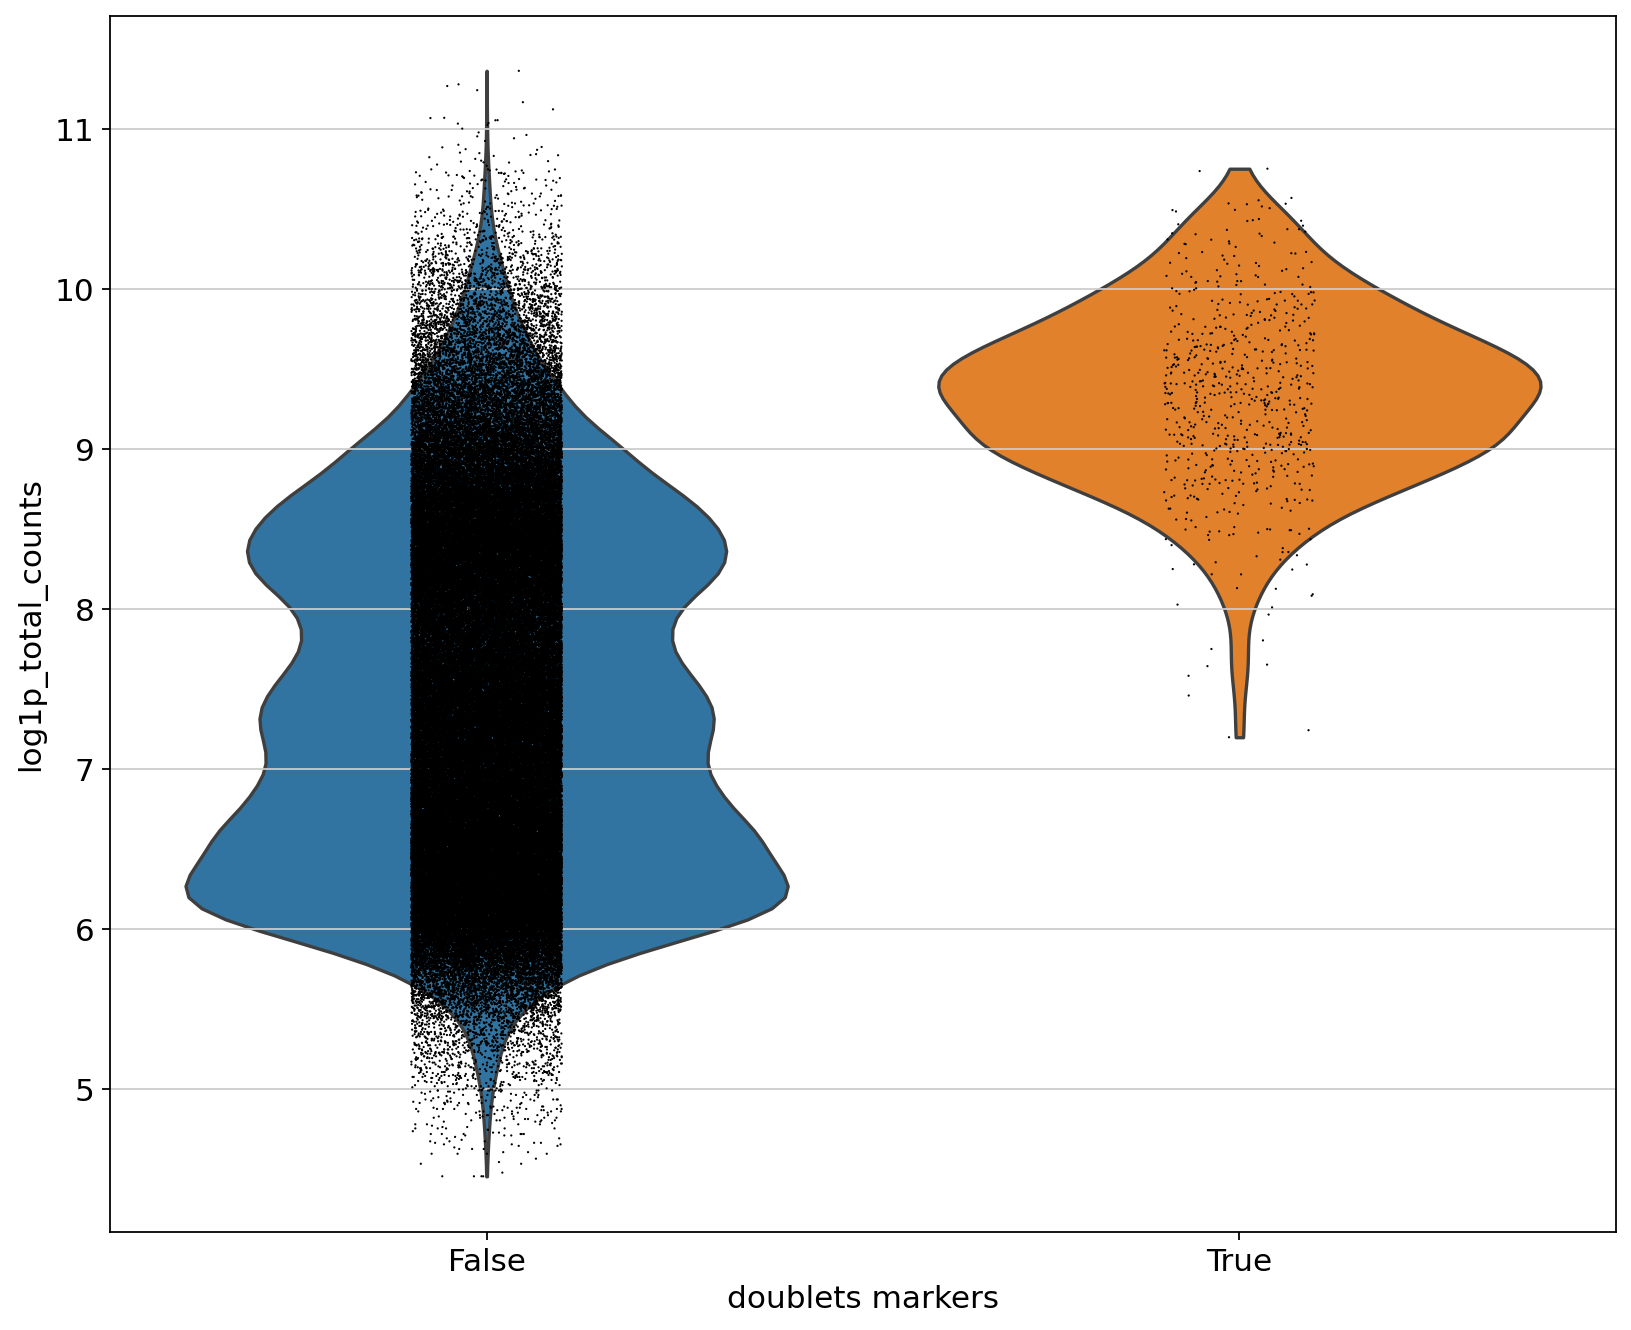

In [9]:
sc.pl.violin(filtered["prot"], keys="log1p_total_counts", groupby="doublets_markers")

Doublets usually have a higher count due to the presence of increased counts from more than one cell. We can see this effect in the cells classified as doublets using our markers.

In [10]:
filtered.update()

In [11]:
filtered = filtered[filtered.obs.loc[filtered["prot"].obs_names].index]

In [12]:
filtered = filtered[filtered["prot"].obs["doublets_markers"] == "False"]

In [13]:
filtered

View of MuData object with n_obs × n_vars = 119837 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	119837 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	119837 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors'
      layers:	'counts'

In [14]:
filtered.write(filtered_xdbt_mu_path)

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/anndata/_core/anndata.py:1241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'feature_types' as categorical


## Key takeaways

TODO

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Daniel Strobl
* Ciro Suast

### Reviewers

* Lukas Heumos